# Лабораторная работа №2. Получение навыков работы с методами классификации
## Выполнил: Заборин Станислав, 15-АС
### Вариант 6
### Задания:
1.	Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).
2.	Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции;
3.	Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)
4.	Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию);
5.	Выполните замену категориальных признаков; выберите и обоснуйте способ замены;
6.	Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации);
7.	Заполните пропущенные значения в данных;
8.	Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию. 
9.	Сравните кривые для классификаторов, указанных в задании, сделайте выводы.

#### Настройка окружения

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

titanic_df = pd.read_excel("titanic3.xls")
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 107.4+ KB


### 1. Изучение набора данных

#### Описание набора данных
Содержит информацию о пассажирах Титаника. Не содержит информации об экипаже, но для 80% пассажиров определен (точно или приблизительно) возраст. 
#### Словарь данных
1.  pclass    - класс билета (1 - первый, 2 - второй, 3 - третий)
2.  survived  - выжил (1 - да, 0 - нет)
3.  name      - имя пассажира
4.  sex       - пол пассажира
5.  age       - возраст (дробное - если меньше 1 года, в формате xx.5 - если вычислено приблизительно)
6.  sibsp     - количество братьев/сестер и супругов на борту
7.  parch     - количество родителей и детей на борту
8.  ticket    - номер билета
9.  fare      - пассажирский тариф
10. сabin     - номер каюты
11. embarked  - порт посадки (C - Шербург, Q - Квинстаун, S - Саутгемптон)
12. boat      - идентификатор сапсательной лодки
13. body      - идентификатор найденного тела
14. home.dest - дом/пункт назначения

### 2. Удаление дубликатов строк

In [2]:
print("Shape before deleting:\n{}".format(titanic_df.shape))

titanic_df = titanic_df.drop_duplicates()
print("Shape after duplicates deletion:\n{}".format(titanic_df.shape))

Shape before deleting:
(1309, 14)
Shape after duplicates deletion:
(1309, 14)


### 3. Оценка сбалансированности классов 

    Died: 809
Survived: 500


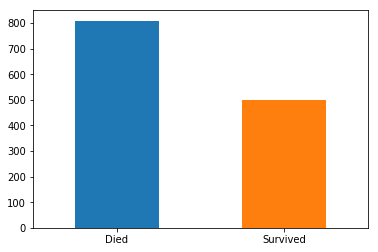

In [3]:
fmt_str = "{0:>8}: {2[0]}\n{1:>8}: {2[1]}"
value_counts = titanic_df['survived'].value_counts()
print(fmt_str.format("Died", "Survived", value_counts))
value_counts.plot(kind='bar')
plt.xticks(np.arange(2), ("Died", "Survived"), rotation=0)
plt.show()

### 4. Замена категориальных признаков

In [4]:
# deleting senseless features
senseless_features = ['name', 'home.dest', 'ticket', 'cabin']
sense_titanic_df = titanic_df.drop(senseless_features, axis=1)

# transforming categorical features
sense_titanic_df = pd.get_dummies(sense_titanic_df, columns=['pclass', 'embarked'])
sense_titanic_df['sex']  = sense_titanic_df['sex'].transform(lambda x: 1 if x == 'male' else 0)
sense_titanic_df['boat'] = sense_titanic_df['boat'].transform(lambda x: 1 if pd.notnull(x) else 0)
sense_titanic_df['body'] = sense_titanic_df['body'].transform(lambda x: 1 if pd.notnull(x) else 0)

sense_titanic_df.head()

,survived,sex,age,sibsp,parch,fare,boat,body,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S
0,1,0,29.0000,0,0,211.3375,1,0,1,0,0,0,0,1
1,1,1,0.9167,1,2,151.5500,1,0,1,0,0,0,0,1
2,0,0,2.0000,1,2,151.5500,0,0,1,0,0,0,0,1
3,0,1,30.0000,1,2,151.5500,0,1,1,0,0,0,0,1
4,0,0,25.0000,1,2,151.5500,0,0,1,0,0,0,0,1


### 5. Заполнение пропущенных значений

In [5]:
# filling empty values
sense_titanic_df['age'].fillna(sense_titanic_df['age'].median(), inplace=True)
sense_titanic_df['fare'].fillna(sense_titanic_df['fare'].median(), inplace=True)

sense_titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 14 columns):
survived      1309 non-null int64
sex           1309 non-null int64
age           1309 non-null float64
sibsp         1309 non-null int64
parch         1309 non-null int64
fare          1309 non-null float64
boat          1309 non-null int64
body          1309 non-null int64
pclass_1      1309 non-null uint8
pclass_2      1309 non-null uint8
pclass_3      1309 non-null uint8
embarked_C    1309 non-null uint8
embarked_Q    1309 non-null uint8
embarked_S    1309 non-null uint8
dtypes: float64(2), int64(6), uint8(6)
memory usage: 131.7 KB


### 6. Масштабирование признаков

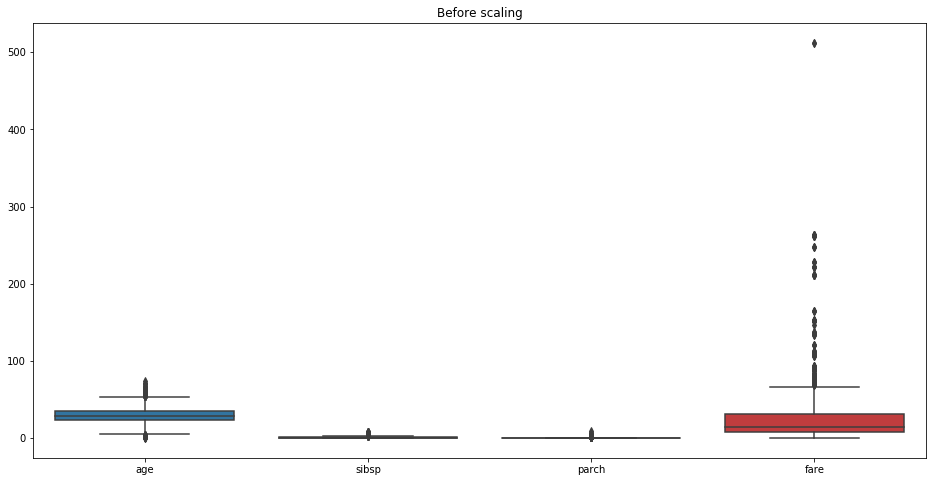

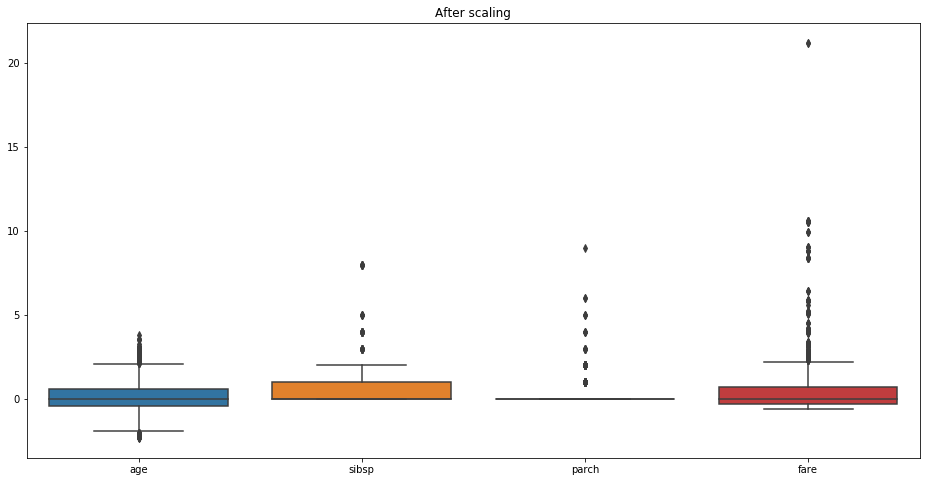

In [6]:
# splitting data
titanic_x = sense_titanic_df.filter(regex="^(?!survived$).*")
titanic_y = sense_titanic_df['survived']
X_train, X_test, y_train, y_test = train_test_split(titanic_x, titanic_y, random_state=0)

numeric_features = ['age', 'sibsp', 'parch', 'fare']

# before scaling
plt.figure(figsize=(16, 8))
sns.boxplot(data=X_train[numeric_features])
plt.title("Before scaling")
plt.show()

# scaling
scaler = RobustScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# after scaling
plt.figure(figsize=(16, 8))
sns.boxplot(data=X_train[numeric_features])
plt.title("After scaling")
plt.show()

### 7. Оценка корреляции признаков

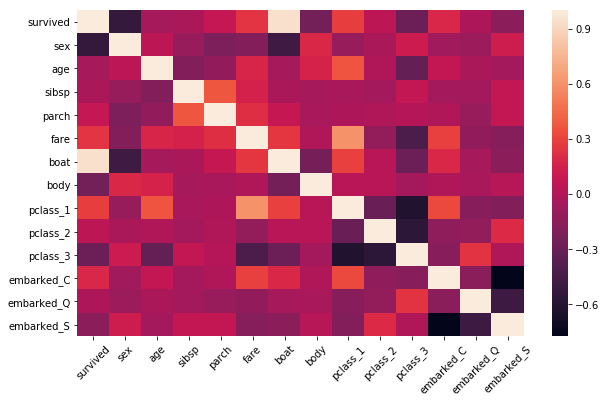

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(sense_titanic_df.corr())
plt.xticks(rotation=45)
plt.show()

### 8. Решение задачи классификации

#### KNeighborsClassifier

In [8]:
param_grid = {'n_neighbors': list(range(1, 20))}

knc_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=4)
knc_search.fit(X_train, y_train)

print("Test score: {:.3f}".format(knc_search.score(X_test, y_test)))
print("Best parameters: {}".format(knc_search.best_params_))
print('\n')
print(classification_report(y_test, knc_search.predict(X_test), target_names=['Survived', 'Died']))

Test score: 0.924
Best parameters: {'n_neighbors': 1}


             precision    recall  f1-score   support

   Survived       0.93      0.95      0.94       208
       Died       0.91      0.88      0.89       120

avg / total       0.92      0.92      0.92       328



#### DecisionTreeClassifier

In [9]:
param_grid = {
    'max_depth': list(range(1, 5)),
    'max_leaf_nodes': list(range(2, 32)),
    'min_samples_leaf': list(range(1, 10))}

dtc_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=4)
dtc_search.fit(X_train, y_train)

print("Test score: {:.3f}".format(dtc_search.score(X_test, y_test)))
print("Best parameters: {}".format(dtc_search.best_params_))
print('\n')
print(classification_report(y_test, dtc_search.predict(X_test), target_names=['Survived', 'Died']))

Test score: 0.963
Best parameters: {'max_depth': 1, 'max_leaf_nodes': 2, 'min_samples_leaf': 1}


             precision    recall  f1-score   support

   Survived       0.96      0.98      0.97       208
       Died       0.97      0.93      0.95       120

avg / total       0.96      0.96      0.96       328



#### PR curves

In [10]:
def print_curves(x_kn, y_kn, x_dt, y_dt, names, title):
    plt.figure(figsize=(10, 10))
    plt.plot(x_kn, y_kn, label="KNeighborsClassifier {} curve".format(names['curve_name']))
    plt.plot(x_dt, y_dt, label="DecisionTreeClassifier {} curve".format(names['curve_name']))
    plt.legend(loc=8, fontsize='large')
    plt.title(title)
    plt.xlabel(names['xlabel'])
    plt.ylabel(names['ylabel'])
    plt.show()

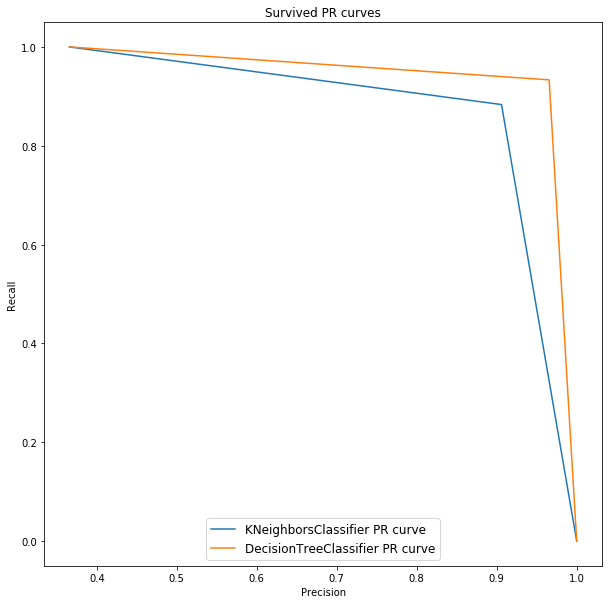

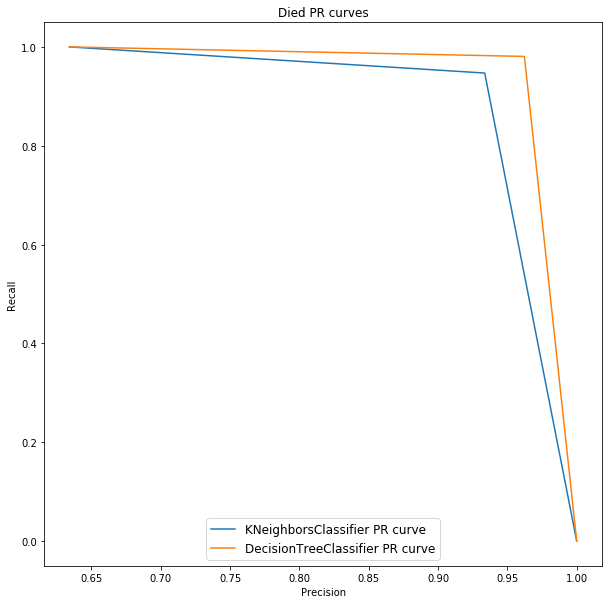

In [11]:
survived, died = y_test == 1, y_test == 0
knc_probas_survived = knc_search.predict_proba(X_test)[:, 1]
dtc_probas_survived = dtc_search.predict_proba(X_test)[:, 1]
knc_probas_died = knc_search.predict_proba(X_test)[:, 0]
dtc_probas_died = dtc_search.predict_proba(X_test)[:, 0]


pr_names = {'curve_name': 'PR', 'xlabel': 'Precision', 'ylabel': 'Recall'}
precision_kn, recall_kn, _ = precision_recall_curve(survived, knc_probas_survived)
precision_dt, recall_dt, _ = precision_recall_curve(survived, dtc_probas_survived)
print_curves(precision_kn, recall_kn, precision_dt, recall_dt, pr_names, "Survived PR curves")

precision_kn, recall_kn, _ = precision_recall_curve(died, knc_probas_died)
precision_dt, recall_dt, _ = precision_recall_curve(died, dtc_probas_died)
print_curves(precision_kn, recall_kn, precision_dt, recall_dt, pr_names, "Died PR curves")

#### ROC curves

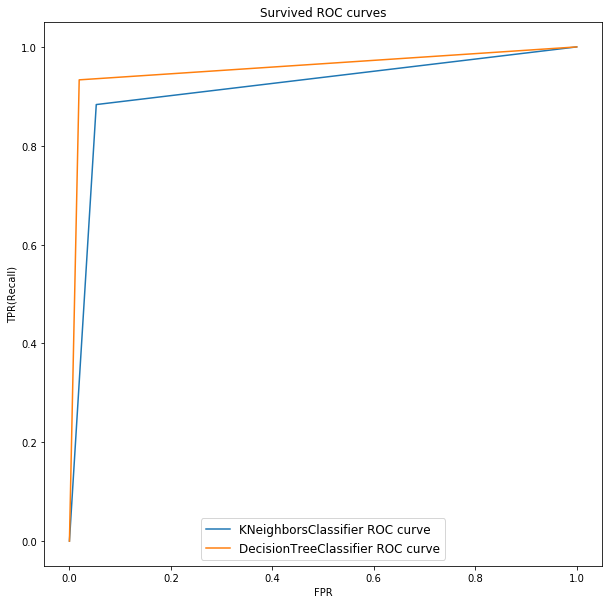

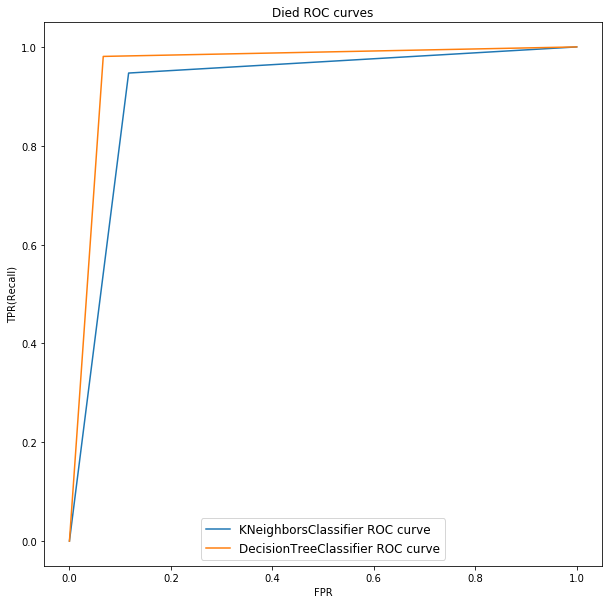

In [12]:
roc_names = {'curve_name': 'ROC', 'xlabel': 'FPR', 'ylabel': 'TPR(Recall)'}
fpr_kn, tpr_kn, _ = roc_curve(survived, knc_probas_survived)
fpr_dt, tpr_dt, _ = roc_curve(survived, dtc_probas_survived)
print_curves(fpr_kn, tpr_kn, fpr_dt, tpr_dt, roc_names, "Survived ROC curves")

fpr_kn, tpr_kn, _ = roc_curve(died, knc_probas_died)
fpr_dt, tpr_dt, _ = roc_curve(died, dtc_probas_died)
print_curves(fpr_kn, tpr_kn, fpr_dt, tpr_dt, roc_names, "Died ROC curves")